In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))

['test', 'train', 'train.csv', 'sample_submission.csv']


In [2]:
from fastai import *
from fastai.vision import *
import torch

In [3]:
data_folder = Path("../input")

In [4]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/sample_submission.csv")

In [5]:
test_img = ImageList.from_df(test_df, path=data_folder/'test', folder='test')
trfm = get_transforms(do_flip=True, flip_vert=True, max_rotate=10.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)
train_img = (ImageList.from_df(train_df, path=data_folder/'train', folder='train')
        .split_by_rand_pct(0.01)
        .label_from_df()
        .add_test(test_img)
        .transform(trfm, size=128)
        .databunch(path='.', bs=64, device= torch.device('cuda'))
        .normalize(imagenet_stats)
       )

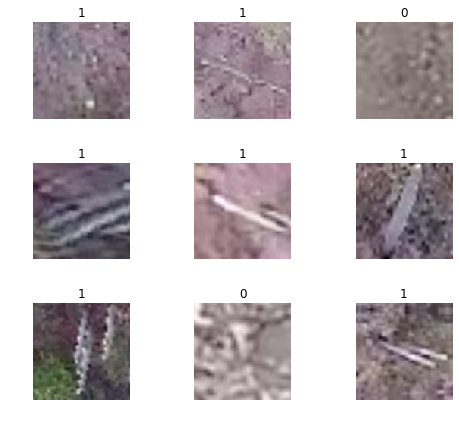

In [6]:
train_img.show_batch(rows=3, figsize=(7,6))

In [7]:
print(train_img.classes)
print("No. of classes : {}".format(train_img.c))

[0, 1]
No. of classes : 2


In [8]:
learner = cnn_learner(train_img, models.densenet161, metrics=[accuracy, error_rate])

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /tmp/.torch/models/densenet161-8d451a50.pth
115730790it [00:05, 20262400.36it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-04


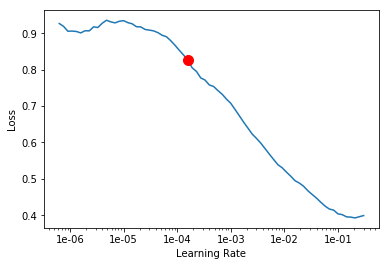

In [9]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [10]:
learner.fit_one_cycle(5, max_lr=slice(3e-02))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.057346,0.079030,0.988571,0.011429,01:33
1,0.046300,0.000685,1.000000,0.000000,01:27
2,0.031888,0.090319,0.960000,0.040000,01:27
3,0.009858,0.000098,1.000000,0.000000,01:26
4,0.002915,0.000036,1.000000,0.000000,01:26


In [11]:
learner.save('stage-1')

In [12]:
interpreter = ClassificationInterpretation.from_learner(learner)

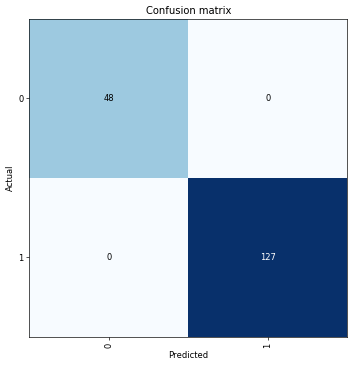

In [13]:
interpreter.plot_confusion_matrix(figsize=(6,6), dpi=60)

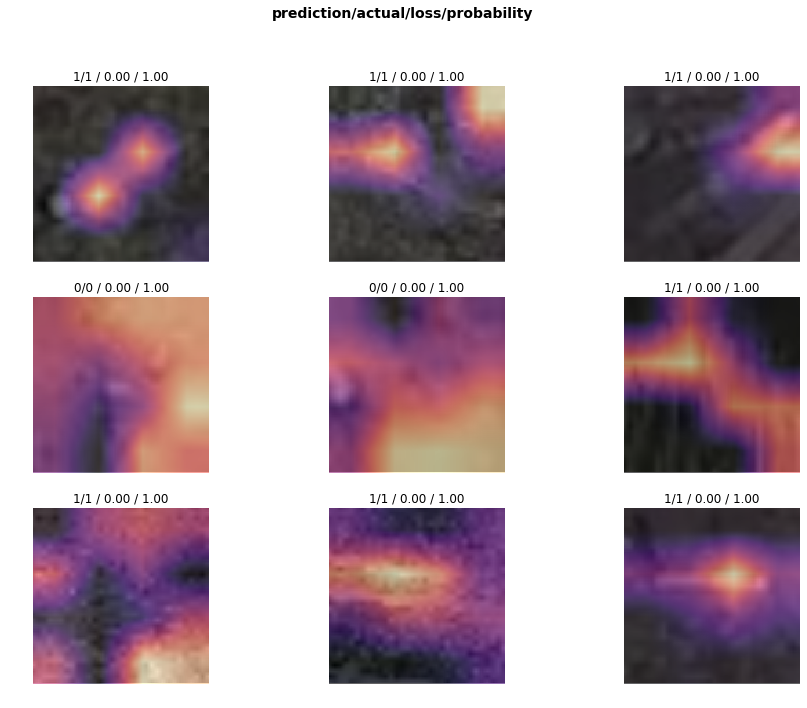

In [14]:
interpreter.plot_top_losses(9, figsize=(15,11))

In [15]:
preds,_ = learner.get_preds(ds_type=DatasetType.Test)
test_df.has_cactus = preds.numpy()[:, 0]
test_df.to_csv("submission.csv", index=False)